<h1>Ensemble</h1>

# import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, load_breast_cancer

# Ensemble(앙상블) 기법
* 여러 머신러닝 모델을 결합해서 더 강력한 모델을 만드는 기법
* 여러 전문가의 의견을 종합하는 경우와 흡사
* 대표적인 앙상블 기법
  * Voting(보팅)
    * 서로 다른 알고리즘 분류기 결합
    * 여러 모델의 예측 결과로 투표해서 최종 결정
  * Bagging(배깅, bootstrap aggregating)
    * 같은 알고리즘(결정트리) 결합, 서로 다른 훈련 데이타 샘플로 훈련
    * 샘플을 여러번 뽑아(Bootstrap) 각 모델을 학습 시킨 결과를 집계(Aggregation)
    * Random Forest(랜덤 포레스트) : 대표적인 Bagging 알고리즘
  * Boosting(부스팅)
    * 여러 모델이 순차적으로 학습
    * 이전 모델의 결과에 따라 다음 모델에 가중치 부여
  * Stacking(스태킹, Stacked generalization)
    * 여러 모델이 예측한 결과 값을 다른 모델의 학습 데이타로 입력하여 재학습



## Voting
* Hard voting(직접 투표)
  * 각 모델의 예측 결과 중 많은 것을 선택
    * 1 예측 : 3표
    * 2 예측 : 1표
* Soft voting(간접 투표)
  * 각 모델의 클래스 확률
  * 평균 높은 확률을 선택
* 일반적으로 soft voting이 고성능
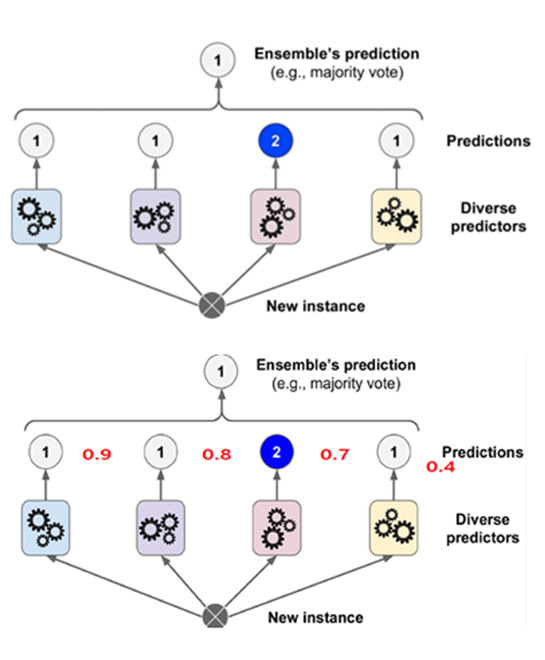


* [sklearn.ensemble.VotingClassifier(estimators, voting ... )](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
  * estimators : voting에 참여할 모델들, [('str', estimator),..]
  * voting : 'hard'(default), 'soft'


* 유방암 데이터 실습

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()
X = StandardScaler().fit_transform(cancer.data)
X_train, X_test, y_train, y_test = train_test_split(X, cancer.target, random_state=0)

lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=8)
dt = DecisionTreeClassifier(max_depth=5, random_state=0)
voting = VotingClassifier(estimators=[('LR', lr), ('KNN', knn), ('dt', dt)], voting='soft')

for cl in [voting, lr, knn, dt] :
    cl.fit(X_train, y_train)
    acc = cl.score(X_test, y_test)
    name = cl.__class__.__name__
    print(f'{name} Accuracy: {acc:.2%}')


VotingClassifier Accuracy: 95.10%
LogisticRegression Accuracy: 96.50%
KNeighborsClassifier Accuracy: 94.41%
DecisionTreeClassifier Accuracy: 89.51%


## Bagging, RandomForest
* 같은 알고리즘(결정트리) 결합, 서로 다른 훈련 데이타 샘플로 훈련
* RandomForest
  * 대표적 배깅(bagging) 알고리즘
  * 여러개의 결정트리 생성 후 데이타 세트로 부터 각자의 샘플을 랜덤하게 추출해서 학습
  * 모든 분류기가 보팅(voting)해서 예측 결정
* 조금씩 다른 여러개의 결정 트리로 구성
* 각 결정트리는 특정 문제에 과대 적합된 모델

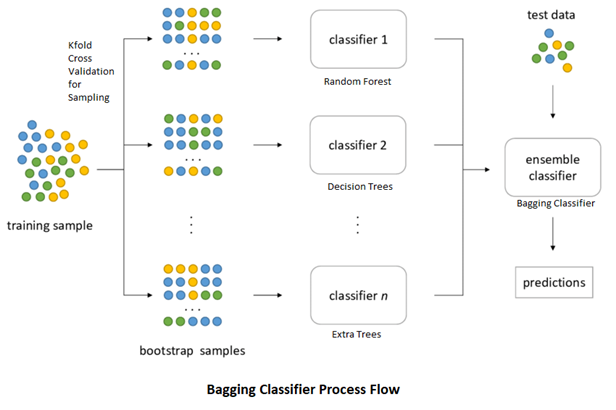

* [sklearn.ensemble.RandomForestClassifier(n_estimators, max_features, ...)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
  * n_estimators : 생성할 트리의 갯수, 클수록 좋지만 훈련시간과 메모리 부담
    * 생성된 트리는 객체의 estimator_ 속성에
  * max_features : 선택할 무작위 특성의 갯수, 핵심 변수, 기본값을 권장
    * 값이 크면 : 트리들이 비슷해짐
    * 값이 작으면 : 트리들이 달라지고 깊어진다.
  * random_state : 생성할 때 마다 달라 질수 있으므로 같은 결과를 원하면 값을 고정


In [ ]:
from sklearn.ensemble import RandomForestClassifier

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)

dt = DecisionTreeClassifier(max_depth=10, random_state=0)
forest = RandomForestClassifier(n_estimators=300, random_state=0, max_depth=10)

for clf in [dt, forest]:
  clf.fit(X_train,y_train)
  acc_train = clf.score(X_train, y_train)
  acc_test = clf.score(X_test, y_test)
  name = clf.__class__.__name__
  print(f"{name}, Train acc:{acc_train:.4f}, Test acc: {acc_test:.4f}")


DecisionTreeClassifier, Train acc:0.9785, Test acc: 0.8222
RandomForestClassifier, Train acc:1.0000, Test acc: 0.9778


## Boosting
* 여러개의 약한 학습기를 순차적으로 연결
* 학습 과정에서 오답에 대해 높은 가중치 부여
* 대표적 부스팅 알고리즘
  * AdaBoost(Adaptive Boosting, 아다부스트)
    * 과소 적합된 훈련 가중치를 더 높여서 새로운 모델 학습
  * GBM(Gradient Boost, 그래디언트 부스트)
    * Loss function의 gradient로 오답 가중치 부여

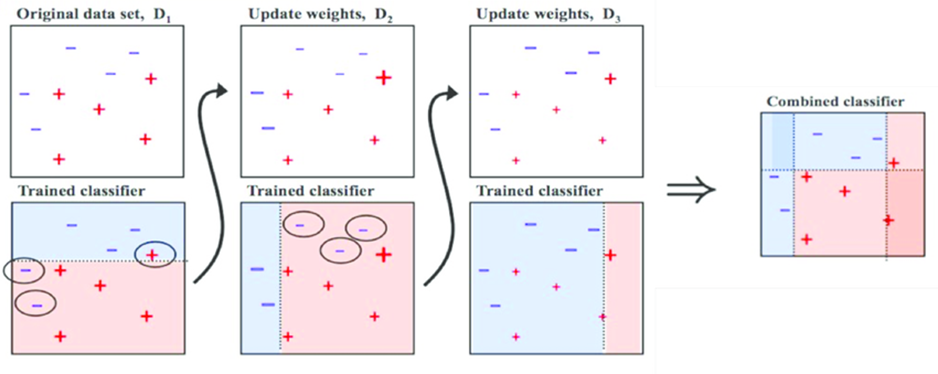

* sklearn.ensemble.AdaBoostClassifier()
* sklearn.ensemble.GradientBoostingClassifier()


### Boosting 숫자 손글씨 실습

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

digits = load_digits()
X = MinMaxScaler().fit_transform(digits.data)
X_train, X_test, y_train, y_test = train_test_split(X, digits.target, random_state=1)

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=0)
gbm_clf = GradientBoostingClassifier(max_depth=3, random_state=0)

for clf in [ada_clf, gbm_clf]:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)
    print(f'{name}\t Train Acc : {acc_train:.4f},  Test Acc : {acc_test:.4f}')

AdaBoostClassifier	 Train Acc : 0.8226,  Test Acc : 0.7289
GradientBoostingClassifier	 Train Acc : 1.0000,  Test Acc : 0.9556


### Boosting 보스턴 주택가격 실습
* sklearn.ensemble.AdaBoostRegressor()
* sklearn.ensemble.GradientBoostingRegressor()


In [ ]:
!pip install -U boston
from boston import load_boston

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

boston = load_boston()
X = StandardScaler().fit_transform(boston.data)
X_train, X_test, y_train, y_test = train_test_split(X, boston.target, random_state=1)

ada_reg = AdaBoostRegressor(random_state=0)
gbm_reg = GradientBoostingRegressor(random_state=0)

for reg in [ada_reg, gbm_reg]:
  reg.fit(X_train, y_train)
  name = reg.__class__.__name__
  r2_train = reg.score(X_train, y_train)
  r2_test = reg.score(X_test, y_test)
  print(f'{name} Train R2:{r2_train:.4f}, Test R2:{r2_test:.4f}')

AdaBoostRegressor Train R2:0.9062, Test R2:0.8417
GradientBoostingRegressor Train R2:0.9809, Test R2:0.9243


## XGBoost(eXtra Gradient Boost)
* GBM의 단점인 느린 수행 시간 해결
* 과적합 규제(Regularization) 가능
* 자체적인 교차 검증 수행
* scikit-learn과 별도로 설치 필요
  * `pip install xgboost`
  * 별도의 패키지이지만 sklearn용 래퍼(wrapper) 제공
    * `XGBClassifier`, `XGBRegressor`
  * https://xgboost.readthedocs.io/en/latest/index.html
  * https://github.com/dmlc/xgboost

### XGBoost 위스콘신 유방암 분류

In [ ]:
import xgboost as xgb

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

model = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=400)
model.fit(X_train, y_train)
print('Train acc: ',model.score(X_train, y_train), 'Test acc: ', model.score(X_test, y_test))

Train acc:  1.0 Test acc:  0.986013986013986


### XGBoost boston 주택 가격 회귀

In [ ]:
!pip install -U boston
from boston import load_boston

In [ ]:
import xgboost as xgb

boston = load_boston()
X = StandardScaler().fit_transform(boston.data)
X_train, X_test, y_train, y_test = train_test_split(X, boston.target, random_state=0)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

print(f'Train R2:{model.score(X_train, y_train):.4f} Test R2:{model.score(X_test, y_test):.4f}')

Train R2:1.0000 Test R2:0.7473


## LightGBM
* 여전히 오래 걸리는 XGBoost 개선
  * 빠른 학습과 예측
  * 적은 메모리 사용
* 단점 : 적은 데이터 학습에서 과접한 발생이 쉽다.
  * 10,000건 이상의 샘플 권장
* scikit-learn과 별도로 설치 필요
  * `pip install lightgbm`
  * sklearn 래퍼 클래스
    * `LGBMClassifier`, `LGBMRegressor`
  * 참조 : https://lightgbm.readthedocs.io/en/latest/


###### LGBM 유방암분류

In [ ]:
from lightgbm import LGBMClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

lgbm_clf = LGBMClassifier(n_estimator=400)
lgbm_clf.fit(X_train, y_train)

print('train score:', lgbm_clf.score(X_train, y_train), 'test score:', lgbm_clf.score(X_test, y_test))



train score: 1.0 test score: 0.972027972027972


###### LGBM 보스턴 주택가격 회귀

In [ ]:
!pip install -U boston
from boston import load_boston

In [ ]:
from lightgbm import LGBMRegressor

boston = load_boston()
X = StandardScaler().fit_transform(boston.data)
X_train, X_test, y_train, y_test = train_test_split(X, boston.target, random_state=0)

model = LGBMRegressor()
model.fit(X_train, y_train)

print(f'Train R2:{model.score(X_train, y_train)}, Test R2:{model.score(X_test, y_test)}')

Train R2:0.9757474489930561, Test R2:0.7438280827089574


## Stacking
* 여러 모델이 예측한 결과 값을 다른 모델의 학습 데이터로 입력하여 재학습
* 성능 향상 보장 없음
* sklearn.ensemble.StackingClassifier()

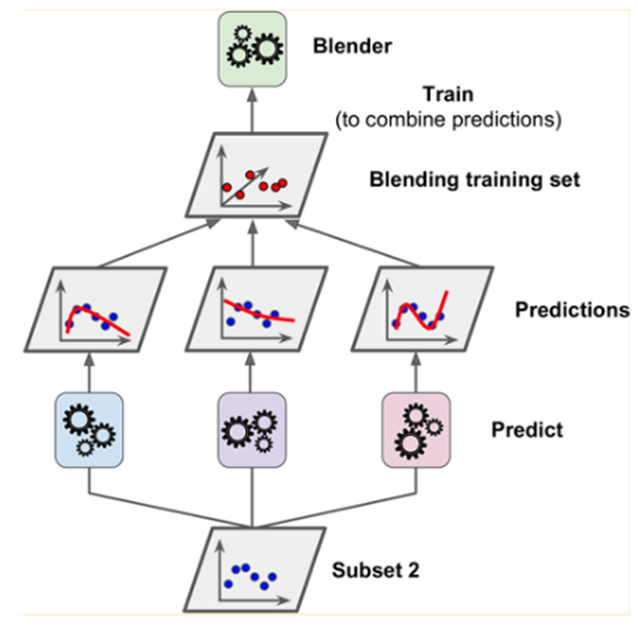

### 유방암 데이터 실습

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=0)
knn = KNeighborsClassifier(4)
rf = RandomForestClassifier(n_estimators=100, random_state=0)
dt = DecisionTreeClassifier(random_state=0)
ada = AdaBoostClassifier(n_estimators=100)
estimators = [('knn', knn), ('rf',rf), ('dt',dt), ('ada',ada)]

lr = LogisticRegression(C=10)
model = StackingClassifier(estimators=estimators, final_estimator=lr)
model.fit(X_train, y_train)
print(f'StackingClassifier: {model.score(X_test, y_test):.2%}')

for m in [knn, rf, dt, ada]:
  m.fit(X_train, y_train)
  score = m.score(X_test, y_test)
  print(f'{m.__class__.__name__}: {score:.2%}')

StackingClassifier: 97.20%
KNeighborsClassifier: 92.31%
RandomForestClassifier: 97.20%
DecisionTreeClassifier: 88.11%
AdaBoostClassifier: 98.60%
